## 1. Fixed P0 and k (manually varying P0 and k)

- Combined two initializations T0=0 and T0=1
- Noise level for tree cover: mu=0.05
- Productivity noise's std=0.05
- P0 = 300mm/yr; k = 3500
- Taken only stationary part
- Check both: with and without noise (100~300mm/yr) in precipitation in dxdt

A: 216.0
B: -172.60403136414914
C: -0.15673045994661072
D: 4.412996908802156
Roots of Teq cubic equation with k=2000: [ 0.76514359  0.18126004 -0.14731089]


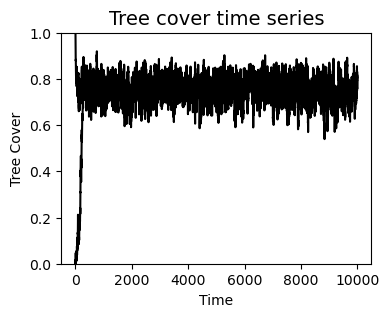

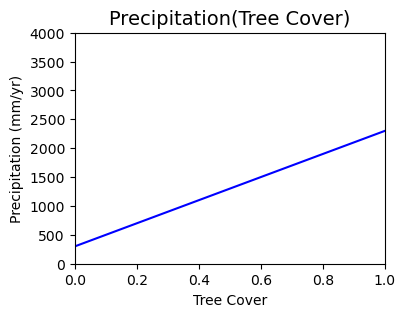

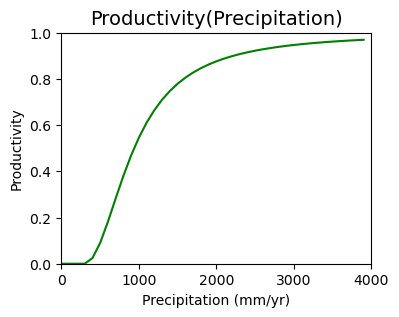

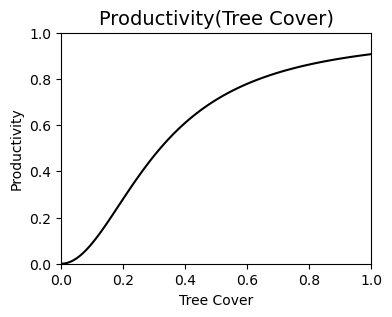

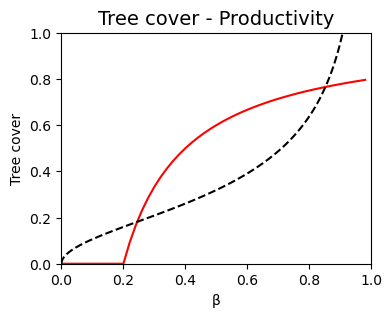

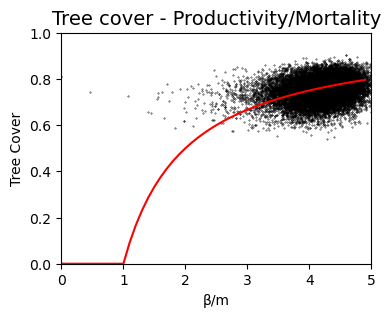

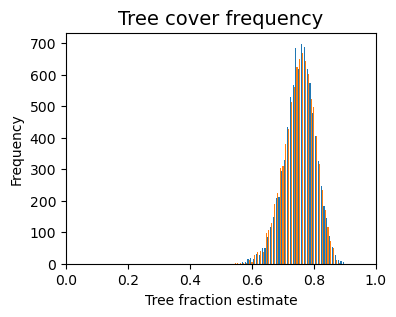

In [118]:
import numpy as np
import matplotlib.pyplot as plt

mort = 0.2  # mortality fixed

# Equilibrium =========================================================================
" f(x) = (b-m)x-bx^2 "
" f(x) = 0 => x=0 or x=1-m/b=1-1/bm (bm: b/m) "
" if b>=m, x=0 unstable and x=1-1/bm stable " 
" df/dx=0 => b-m-2bx = 0 "
bm_eq = np.arange(0.000001, 5, 0.1)
x_eq = np.zeros(len(bm_eq))
for i, BM in enumerate(bm_eq):
    if BM < 1:
        x_eq[i] = 0
    elif BM >= 1:
        x_eq[i] = 1 - 1/BM

# Definition ==========================================================================
# parameters for productivity(precipitation) equation:
alpha = 0.000054           # original from Bathiany 2013: 0.0011
c = 138                    # original from Bathiany 2013: 28
gamma = 0.00017*9100

P1 = c*np.exp(gamma/2) # =~300                                       # original: 60.68548303127268
P2 = c*np.exp(gamma/2) + np.exp(gamma)/np.sqrt(0.03*alpha) # =~4000  # original: 878.3903705049846

def productivity(p):       # productivity (beta) in function of precipitation (P) - "sigmoid" equation        
    if p < P1:
        beta = 0
    elif P1 <= p <= P2:
        beta = 1.0 - 1.0/(1+alpha*((p-P1)/np.exp(gamma))**2)
    else:
        beta = 1.0
    return beta

def dxdt(x, p0, k):  # control here with or w/o noise in precipitation
    " f(x) = beta*x*(1-x)-m*x "
    nu = 300                                                   # precipitation noise level 100~300mm/year; 0 for no noise
    precip = p0 + k*x + nu*np.random.normal(0, 1)            # graph: p0 - k => how many solutions for each case; T0=0 and T0=1
    prod = productivity(precip) + np.random.normal(0, 0.05)
    return prod*x*(1-x)-mort*x, prod/mort, precip, productivity(precip)

#======================================================================================
np.random.seed(22)
#======================================================================================
time = np.linspace(0, 1000, num=10000)
P0 = 300
k_slope = 2000
mu = 0.05  # noise level in random generation size for tree cover

# Tree cover generation from T0=0.0 and T0=1.0 ========================================
dTdt = np.zeros((len(time),2))
bm = np.zeros((len(time),2))
P = np.zeros((len(time),2))
b = np.zeros((len(time),2))
T = np.zeros((len(time),2))

T[0] = [0.0, 1.0]   # state initialization

# coeffs in the cubic equation in T equilibrium:
A = 1.0*alpha*(k_slope**2)
B = alpha*k_slope*(2.0*(P0-P1)-(1.0-mort)*k_slope)
C = alpha*(P0-P1)*(1.0*(P0-P1)-2*k_slope*(1.0-mort))
D = mort*np.exp(2*gamma)-alpha*(1.0-mort)*(P0-P1)**2
sol = np.roots([A,B,C,D])
print("A:", A)
print("B:", B)
print("C:", C)
print("D:", D)
print("Roots of Teq cubic equation with k={}:".format(k_slope), sol)

for i in range(2):
    for n, dt in enumerate(np.diff(time), 0):
        dTdt[n,i], bm[n,i], P[n,i], b[n,i] = dxdt(T[n,i], P0, k_slope)
        T[n+1,i] = T[n,i] + dTdt[n,i]*dt + mu*np.random.normal(0, np.sqrt(dt))

# Graph ===============================================================================    
# Time series
plt.figure(figsize=(4,3))
plt.plot(T, color='black')
plt.ylim(0,1)
plt.title('Tree cover time series', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Tree Cover') 
plt.show()

# Precipitation (Tree cover)
plt.figure(figsize=(4,3))
plt.plot(np.linspace(0,1,11), P0+k_slope*np.linspace(0,1,11), color='blue')
plt.xlim(0,1)
plt.ylim(0,4000)
plt.title('Precipitation(Tree Cover)', fontsize=14)
plt.xlabel('Tree Cover')
plt.ylabel('Precipitation (mm/yr)')
plt.show()

# Productivity (Precipitation)
PrecGraph = np.arange(0,4000,100)
ProdGraph = np.zeros(len(PrecGraph))
for i, pc in enumerate(PrecGraph):
    ProdGraph[i] = productivity(pc)
plt.figure(figsize=(4,3))
plt.plot(PrecGraph, ProdGraph, color='green')
plt.xlim(0,4000)
plt.ylim(0,1)
plt.title('Productivity(Precipitation)', fontsize=14)
plt.xlabel('Precipitation (mm/yr)')
plt.ylabel('Productivity') 
plt.show()

# Productivity (Tree Cover)
TreeGraph = np.linspace(0,1,100)
ProdGraph2 = np.zeros(len(TreeGraph))
for i, tc in enumerate(TreeGraph):
    ProdGraph2[i] = productivity(P0+k_slope*tc)
plt.figure(figsize=(4,3))
plt.plot(TreeGraph, ProdGraph2, color='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Productivity(Tree Cover)', fontsize=14)
plt.xlabel('Tree Cover')
plt.ylabel('Productivity') 
plt.show()

# Tree cover - Productivity
plt.figure(figsize=(4,3))
plt.plot(bm_eq*mort, x_eq, color='red')
plt.plot(ProdGraph2, TreeGraph, color='black', linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Tree cover - Productivity', fontsize=14)
plt.xlabel('\u03B2')
plt.ylabel('Tree cover') 
plt.show()

# Graph Tree cover - Productivity/Mortality
plt.figure(figsize=(4,3))
plt.plot(bm_eq, x_eq, color='red')
plt.scatter(bm[1000:,], T[1000:,], s=0.1, color='black')
plt.xlim(0,5)
plt.ylim(0,1)
plt.title('Tree cover - Productivity/Mortality', fontsize=14)
plt.xlabel('\u03B2/m')
plt.ylabel('Tree Cover') 
plt.show()

# Tree fraction histogram
plt.figure(figsize=(4,3))
plt.hist(T[1000:,], bins=40)
plt.xlim(0,1)
#plt.ylim(0,100)
plt.title('Tree cover frequency', fontsize=14)
plt.xlabel('Tree fraction estimate')
plt.ylabel('Frequency')
plt.show()

## 2. Multiple p0 and k

C:\Users\eunjooki\AppData\Local\Temp\ipykernel_7860\1866461656.py:71: RuntimeWarning: overflow encountered in exp
  D_y = mort*np.exp(2*gamma*delta)-alpha*(1.0-mort)*(P0-P1)**2
C:\Users\eunjooki\AppData\Local\Temp\ipykernel_7860\1866461656.py:102: RuntimeWarning: overflow encountered in exp
  D_z = mort*np.exp(2*gamma*delta)-alpha*(1.0-mort)*(P0-P1)**2


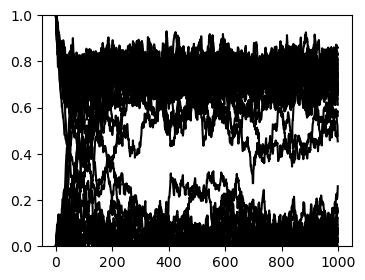

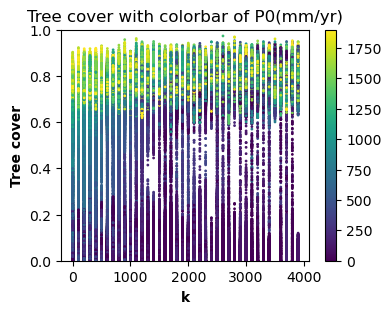

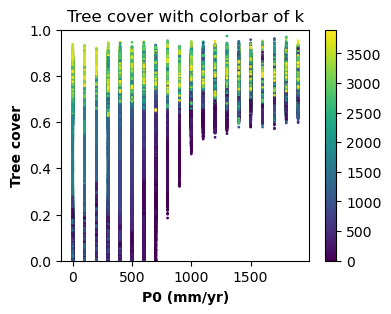

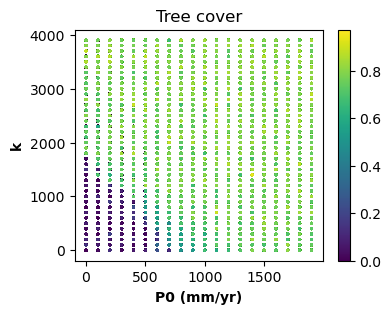

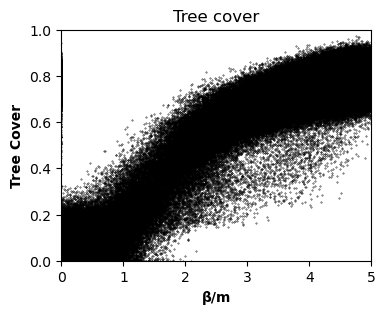

In [128]:
import numpy as np
import matplotlib.pyplot as plt

mort = 0.2  # mortality fixed

# Equilibrium =========================================================================
" f(x) = (b-m)x-bx^2 "
" f(x) = 0 => x=0 or x=1-m/b=1-1/bm (bm: b/m) "
" if b>=m, x=0 unstable and x=1-1/bm stable " 
" df/dx=0 => b-m-2bx = 0 "
bm_eq = np.arange(0.000001, 5, 0.1)
x_eq = np.zeros(len(bm_eq))
for i, BM in enumerate(bm_eq):
    if BM < 1:
        x_eq[i] = 0
    elif BM >= 1:
        x_eq[i] = 1 - 1/BM

# Definition =========================================================================
# parameters for productivity(precipitation) equation:
alpha = 0.000054           # original from Bathiany 2013: 0.0011
c = 138                    # original from Bathiany 2013: 28
gamma = 0.00017*9100

P1 = c*np.exp(gamma/2) # =~300                                       # original: 60.68548303127268
P2 = c*np.exp(gamma/2) + np.exp(gamma)/np.sqrt(0.03*alpha) # =~4000  # original: 878.3903705049846

def productivity(p):  # productivity (beta) in function of precipitation (P) - "sigmoid" equation        
    if p < P1:
        beta = 0
    elif P1 <= p <= P2:
        beta = 1.0 - 1.0/(1+alpha*((p-P1)/np.exp(gamma))**2)
    else:
        beta = 1.0
    return beta

def dxdt(x, p0, k):
    " f(x) = beta*x*(1-x)-m*x "
    precip = p0 + k*x                # graph: p0 - k => how many solutions for each case; T0=0 and T0=1
    prod = productivity(precip) + np.random.normal(0, 0.05)
    return prod*x*(1-x)-mort*x, prod/mort, precip, productivity(precip)

#======================================================================================
np.random.seed(22)
#======================================================================================
time = np.linspace(0, 100, num=1000)
k_range = np.arange(0, 4000, 100)
P0_range = np.arange(0, 2000, 100)
mu = 0.05                                                 # noise level in random generation size for tree cover
nu = 0  # w/o noise in P0 and k

# Tree cover generation from T0=0.0 ======================================================================================
dTdt_y = np.zeros((len(time), len(k_range), len(P0_range)))
bm_y = np.zeros((len(time), len(k_range), len(P0_range)))
P_y = np.zeros((len(time), len(k_range), len(P0_range)))
b_y = np.zeros((len(time), len(k_range), len(P0_range)))
T_y = np.zeros((len(time), len(k_range), len(P0_range)))

P0_y = np.zeros((len(time), len(k_range), len(P0_range)))
k_y = np.zeros((len(time), len(k_range), len(P0_range)))

T0_y = np.full((len(k_range), len(P0_range)), 0.0)            #Tree Cover initialization

T_y[0] = T0_y   # state initialization
for j, P0 in enumerate(P0_range):
    for i, k_slope in enumerate(k_range):
        # coeffs in the cubic equation in T equilibrium:
        A_y = 1.0*alpha*(k_slope**2)
        B_y = alpha*k_slope*(2.0*(P0-P1)-(1.0-mort)*k_slope)
        C_y = alpha*(P0-P1)*(1.0*(P0-P1)-2*k_slope*(1.0-mort))
        D_y = mort*np.exp(2*gamma*delta)-alpha*(1.0-mort)*(P0-P1)**2
        #sol_y = np.roots([A_y,B_y,C_y,D_y])
        for n, dt in enumerate(np.diff(time), 0):
            P0_y[n+1,i,j] = P0 + nu*np.random.normal(0, np.sqrt(time[-1]/time.size))
            k_y[n+1,i,j] = k_slope + nu*np.random.normal(0, np.sqrt(time[-1]/time.size))
            dTdt_y[n,i,j], bm_y[n,i,j], P_y[n,i,j], b_y[n,i,j] = dxdt(T_y[n,i,j], P0, k_slope)
            T_y[n+1,i,j] = T_y[n,i,j] + dTdt_y[n,i,j]*dt + mu*np.random.normal(0, np.sqrt(dt))
            if T_y[n+1,i,j]>1:
                T_y[n+1,i,j]=1
            elif T_y[n+1,i,j]<0:
                T_y[n+1,i,j]=0
                
# Tree cover generation from T0=1.0 ======================================================================================
dTdt_z = np.zeros((len(time), len(k_range), len(P0_range)))
bm_z = np.zeros((len(time), len(k_range), len(P0_range)))
P_z = np.zeros((len(time), len(k_range), len(P0_range)))
b_z = np.zeros((len(time), len(k_range), len(P0_range)))
T_z = np.zeros((len(time), len(k_range), len(P0_range)))

P0_z = np.zeros((len(time), len(k_range), len(P0_range)))
k_z = np.zeros((len(time), len(k_range), len(P0_range)))

T0_z = np.full((len(k_range), len(P0_range)), 1.0)            #Tree Cover initialization

T_z[0] = T0_z   # state initialization
for j, P0 in enumerate(P0_range):
    for i, k_slope in enumerate(k_range):
        # coeffs in the cubic equation in T equilibrium:
        A_z = 1.0*alpha*(k_slope**2)
        B_z = alpha*k_slope*(2.0*(P0-P1)-(1.0-mort)*k_slope)
        C_z = alpha*(P0-P1)*(1.0*(P0-P1)-2*k_slope*(1.0-mort))
        D_z = mort*np.exp(2*gamma*delta)-alpha*(1.0-mort)*(P0-P1)**2
        #sol_z = np.roots([A_z,B_z,C_z,D_z])
        for n, dt in enumerate(np.diff(time), 0):
            P0_z[n+1,i,j] = P0 + nu*np.random.normal(0, np.sqrt(time[-1]/time.size))
            k_z[n+1,i,j] = k_slope + nu*np.random.normal(0, np.sqrt(time[-1]/time.size))
            dTdt_z[n,i,j], bm_z[n,i,j], P_z[n,i,j], b_z[n,i,j] = dxdt(T_z[n,i,j], P0, k_slope)
            T_z[n+1,i,j] = T_z[n,i,j] + dTdt_z[n,i,j]*dt + mu*np.random.normal(0, np.sqrt(dt))
            if T_z[n+1,i,j]>1:
                T_z[n+1,i,j]=1
            elif T_z[n+1,i,j]<0:
                T_z[n+1,i,j]=0
                
# Graph ==============================================================================
plt.figure(figsize=(4,3))
plt.plot(T_y[:,5], color='black')
plt.plot(T_z[:,5], color='black')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(4,3))
plt.scatter(k_y[250:], T_y[250:], c=P0_y[250:], s=1)
plt.scatter(k_z[250:], T_z[250:], c=P0_z[250:], s=1)
plt.colorbar()
plt.ylim(0,1)
plt.xlabel('k', fontweight='bold')
plt.ylabel('Tree cover', fontweight='bold')
plt.title('Tree cover with colorbar of P0(mm/yr)')
plt.show()

plt.figure(figsize=(4,3))
plt.scatter(P0_y[250:], T_y[250:], c=k_y[250:], s=1) 
plt.scatter(P0_z[250:], T_z[250:], c=k_z[250:], s=1) 
plt.colorbar()
plt.ylim(0,1)
plt.xlabel('P0 (mm/yr)', fontweight='bold')
plt.ylabel('Tree cover', fontweight='bold')
plt.title('Tree cover with colorbar of k')
plt.show()

plt.figure(figsize=(4,3))
plt.scatter(P0_y[250:], k_y[250:], c=T_y[250:], s=1)
plt.scatter(P0_z[250:], k_z[250:], c=T_z[250:], s=1) 
plt.colorbar()
plt.xlabel('P0 (mm/yr)', fontweight='bold')
plt.ylabel('k', fontweight='bold')
plt.title('Tree cover')
plt.show()

# Tree Cover in function of beta/m
plt.figure(figsize=(4,3))
plt.scatter(bm_y[250:], T_y[250:], s=0.1, color='black')
plt.scatter(bm_z[250:], T_z[250:], s=0.1, color='black')  
plt.xlim(0,5)
plt.ylim(0,1)
plt.xlabel('\u03B2/m', fontweight='bold')
plt.ylabel('Tree Cover', fontweight='bold')
plt.title('Tree cover')
plt.show()